In [1]:
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from matplotlib import animation

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch
    
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer

from samplesizelib.linear.statistical import LikelihoodRatioEstimator
from samplesizelib.linear.models import RegressionModel

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

from IPython.display import HTML

from matplotlib.patches import FancyArrowPatch

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
from torch import nn
from torch import optim

import math

In [2]:
plt.rcParams['savefig.pad_inches'] = 0

In [3]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
        
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    return ax.add_artist(arrow)
    

setattr(Axes3D,'arrow3D',_arrow3D)

In [4]:
def f_tensor(w_1, w_2, batch_x, batch_y):
    r"""
    :param batch_x: tensor of shape batch_size x num_features
    :type batch_x: tensor
    
    :param batch_y: tensor of shape batch_size
    :type batch_y: tensor
    
    :param model: параметры модели
    """
    return ((w_1*torch.sin(w_2*batch_x) - batch_y)**2).mean()


def f(w_1, w_2, batch_x, batch_y):
    r"""
    :param batch_x: tensor of shape batch_size x num_features
    :type batch_x: tensor
    
    :param batch_y: tensor of shape batch_size
    :type batch_y: tensor
    
    :param model: параметры модели
    """
    return ((w_1*np.sin(w_2*batch_x) - batch_y)**2).mean()



In [5]:
np.random.seed(1)
l = 400
n = 2

w_star = np.random.randn(n)

# Генерация данных
X = np.random.randn(l)
Y = w_star[0]*np.sin(w_star[1]*X) + 2*np.random.randn(l)

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=100)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((300,), (300,), (100,), (100,))

In [6]:
X_train_pt = torch.from_numpy(X_train).float()
X_test_pt = torch.from_numpy(X_test).float()

y_train_pt = torch.from_numpy(y_train).float()
y_test_pt = torch.from_numpy(y_test).float()

train_dataset = torch.utils.data.TensorDataset(X_train_pt, y_train_pt)
test_dataset = torch.utils.data.TensorDataset(X_test_pt, y_test_pt)

In [7]:
x = np.linspace(-5, 5)
y = np.linspace(-5, 5)
X, Y = np.meshgrid(x, y)

In [8]:
torch.manual_seed(9)
w = torch.Tensor([3, 2])
w.requires_grad = True
optim = torch.optim.SGD([w], lr=0.1)

list_of_w = []
list_of_w.append(w.detach().cpu().numpy().copy())
list_of_scores = []
list_of_x_batch = []
list_of_y_batch = []

iters = 0
add = False
for i in tqdm(range(1, 40), leave=False):
    generator = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                        batch_size=16, pin_memory=True)
    
    for batch_x, batch_y in generator:
        optim.zero_grad()
        loss = f_tensor(w[0], w[1], batch_x, batch_y)
    
        loss.backward()
        optim.step()
        
        iters += 1
        
        if iters % 30 == 0 or ( iters < 50 and iters % 10 == 0):
            add = True
            list_of_w.append(w.detach().cpu().numpy().copy())
            scores = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    scores[i][j] = f(X[i,j], Y[i,j], batch_x.cpu().numpy(), 
                                     batch_y.cpu().numpy())
            list_of_scores.append(scores)
            list_of_x_batch.append(batch_x)
            list_of_y_batch.append(batch_y)
        else:
            add = False

if not add:
    list_of_w.append(w.detach().cpu().numpy().copy())
    scores = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            scores[i][j] = f(X[i,j], Y[i,j], batch_x.cpu().numpy(), 
                             batch_y.cpu().numpy())
    list_of_scores.append(scores)
    list_of_x_batch.append(batch_x)
    list_of_y_batch.append(batch_y)

list_of_w_sgd = np.array(list_of_w)

In [9]:
len(list_of_w_sgd), len(list_of_scores)

(29, 28)

In [10]:
scores_train = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        scores_train[i][j] = f(X[i,j], Y[i,j], X_train, y_train)

In [11]:
fps = 1 # frame per sec
frn = len(list_of_scores) # frame number of the animation

X, Y = np.meshgrid(x, y)
zarray = np.zeros((X.shape[0], X.shape[1], frn))

for i in range(frn):
    zarray[:,:,i] = list_of_scores[i]
    

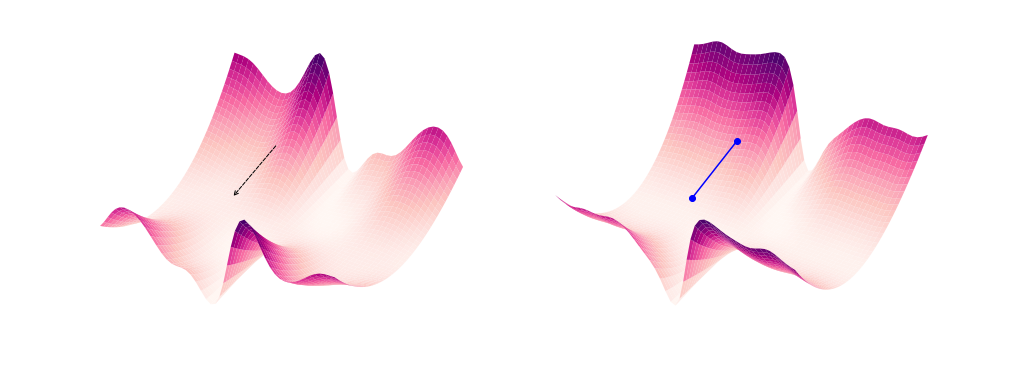

In [43]:
def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, zarray[:,:,frame_number], cmap="RdPu")
    
    plot[1].remove()
    plot[1] = ax2.plot_surface(X, Y, scores_train, cmap="RdPu", alpha=0.99)
    
    if plot[2]:
        plot[2].remove()
    
    ws = list_of_w_sgd[:frame_number+2]
    cur_scores = [f(w_cur[0], w_cur[1], X_train, y_train) for w_cur in ws]
    plot[2], = ax2.plot(ws[:,0], ws[:,1], cur_scores,'-ob')
    
    if plot[3]:
        plot[3].remove()
        
    ws = list_of_w_sgd[frame_number:frame_number+2]
    xs = [list_of_x_batch[frame_number], list_of_x_batch[frame_number]]
    ys = [list_of_y_batch[frame_number], list_of_y_batch[frame_number]]
    cur_scores = [f(w_cur[0], w_cur[1], batch_x, batch_y) for w_cur, batch_x, batch_y in zip(ws, xs, ys)]
    
    line = 1
    plot[3] = ax.arrow3D(ws[0,0],ws[0,1], cur_scores[0],
                          line*(ws[1,0]-ws[0,0]),line*(ws[1,1]-ws[0,1]), line*(cur_scores[1]-cur_scores[0]),
                          mutation_scale=10,
                          arrowstyle="->",
                          linestyle='dashed')
    
    plt.savefig('temp/{}.png'.format(frame_number), bbox_inches = 'tight')


fig = plt.figure(figsize=(18.0, 7.0), frameon=False)
# fig.set_size_inches(200,200)

ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot = [None, None, None, None]
plot[0] = ax.plot_surface(X, Y, zarray[:,:,0], cmap="RdPu", color='0.75')
plot[1] = ax2.plot_surface(X, Y, scores_train, cmap='RdPu', alpha=0.99)

plt.subplots_adjust(hspace = 0, wspace = -0.155)


ax.view_init(60, -150)
ax2.view_init(60, -150)
ax.axis('off')
ax2.axis('off')

plt.autoscale(tight=True)

ani = animation.FuncAnimation(
    fig, update_plot, frn, fargs=(zarray, plot), interval=1000/fps, blit=False)

In [44]:
HTML(ani.to_jshtml())

KeyboardInterrupt: 

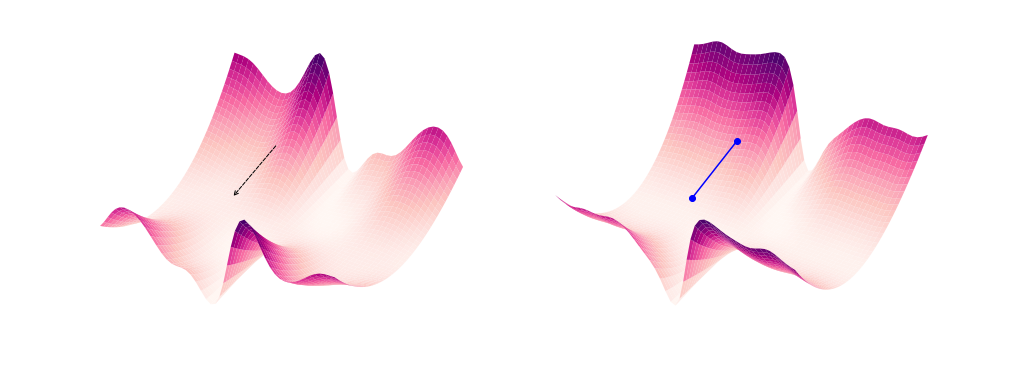

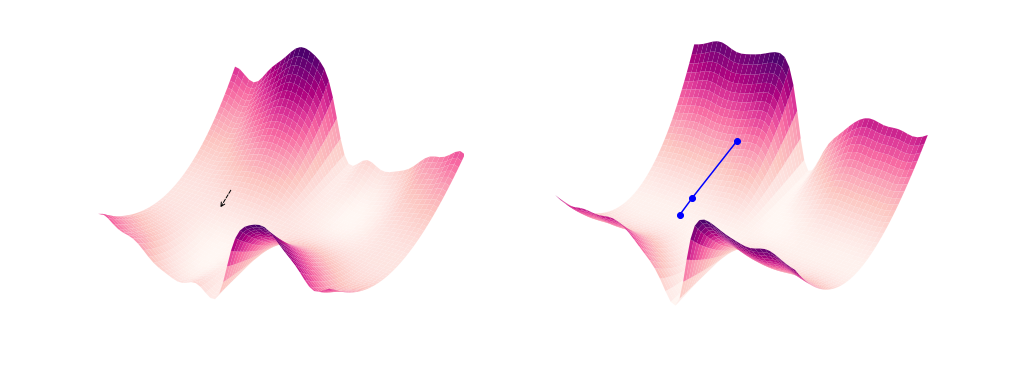

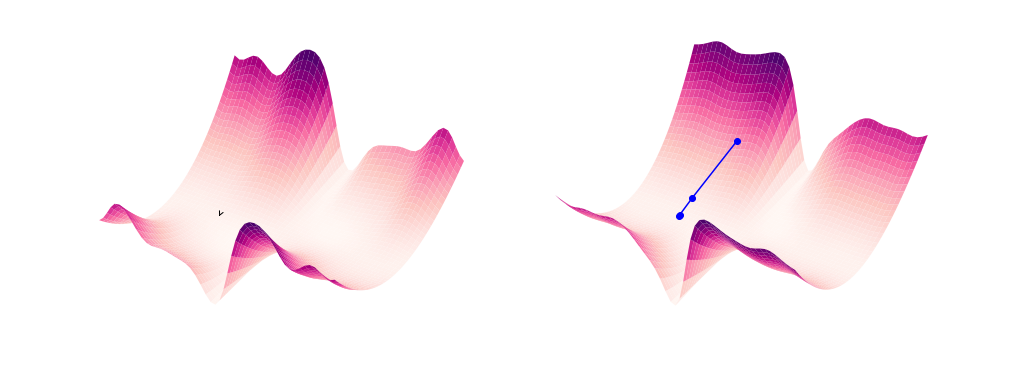

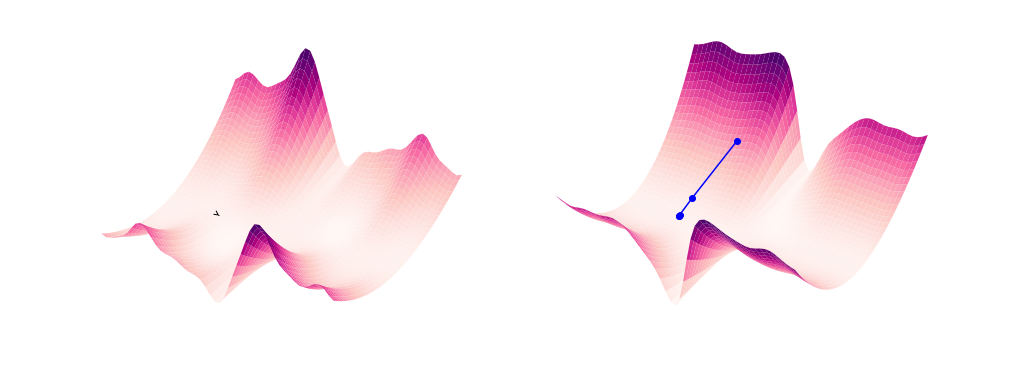

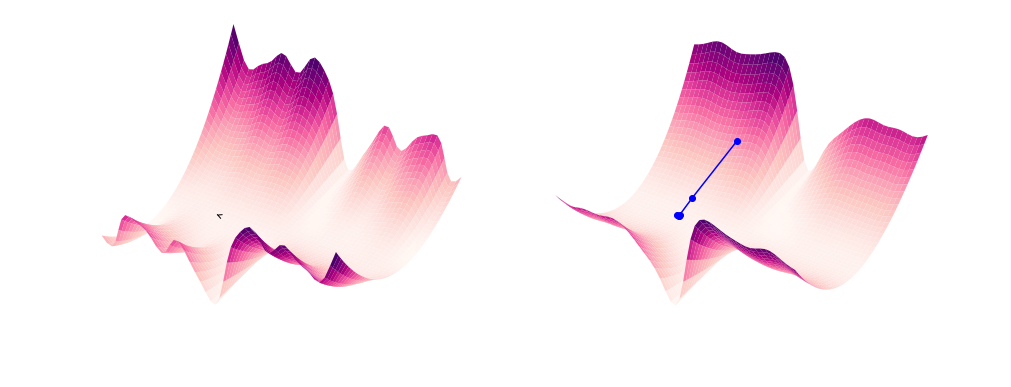

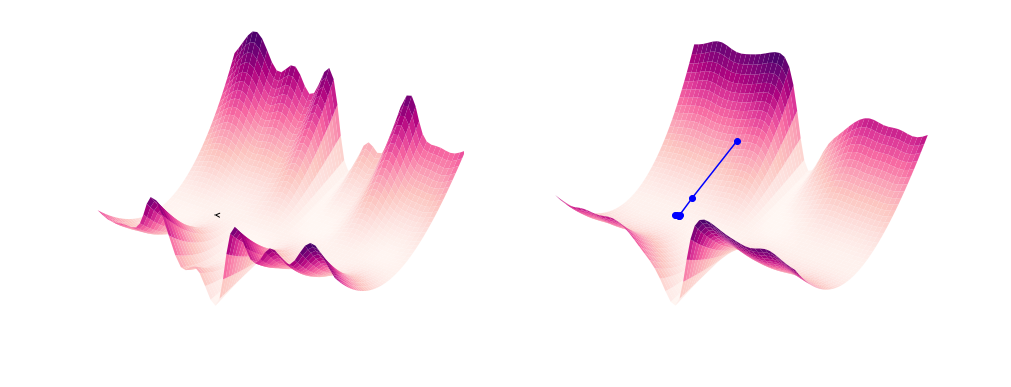

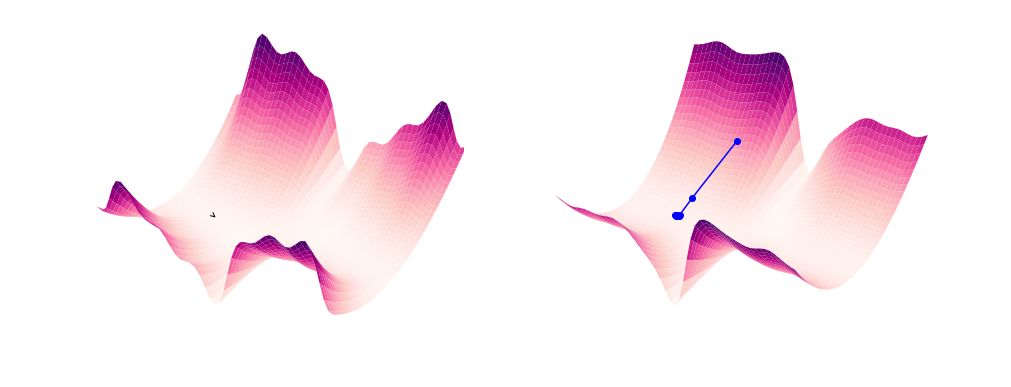

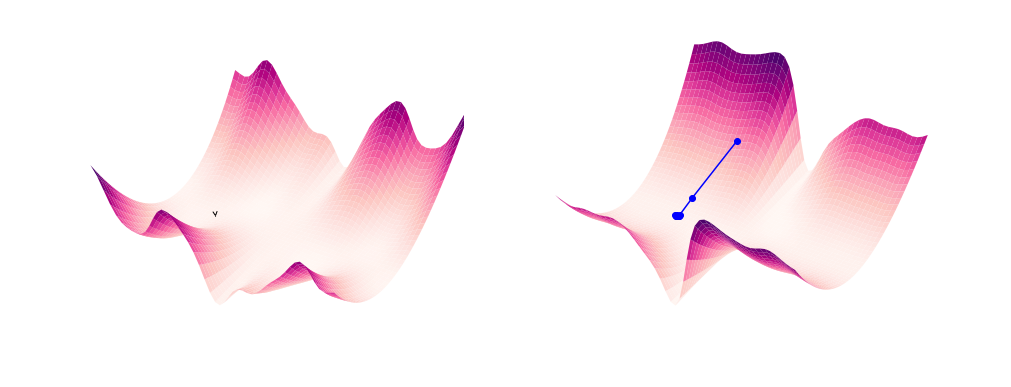

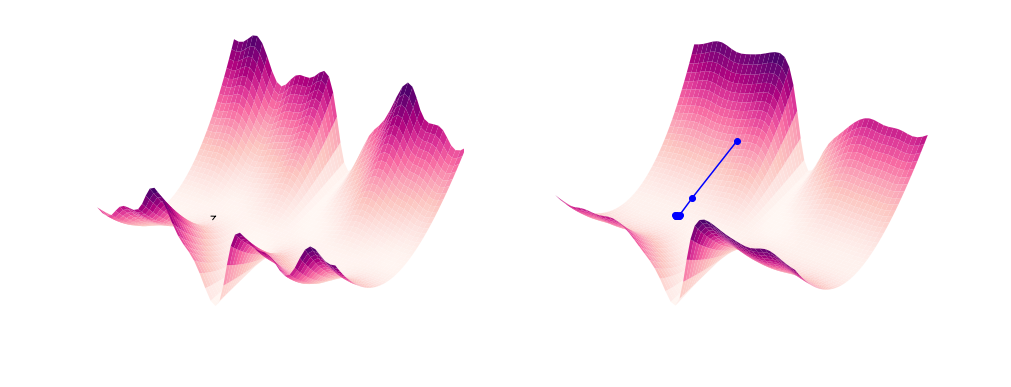

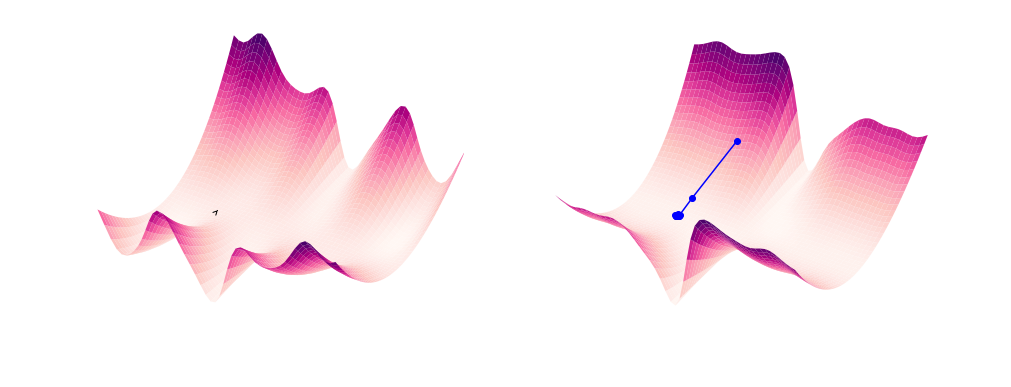

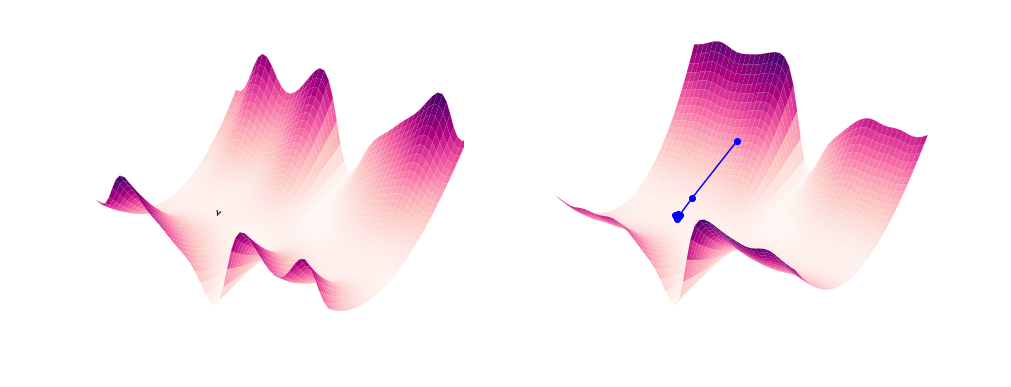

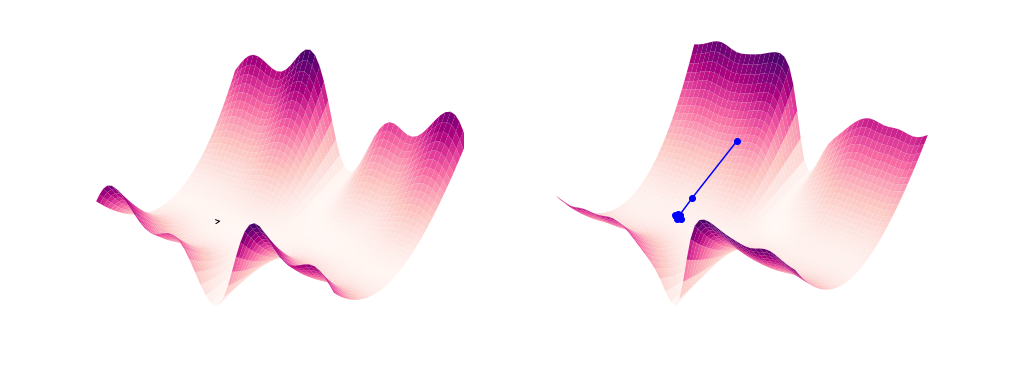

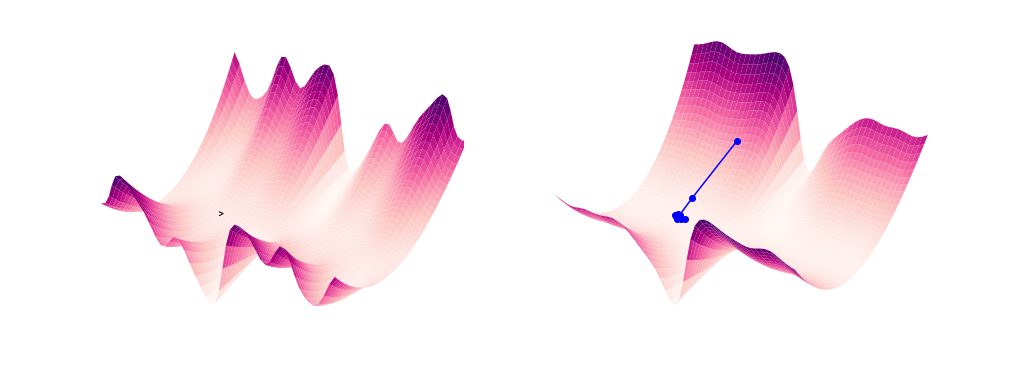

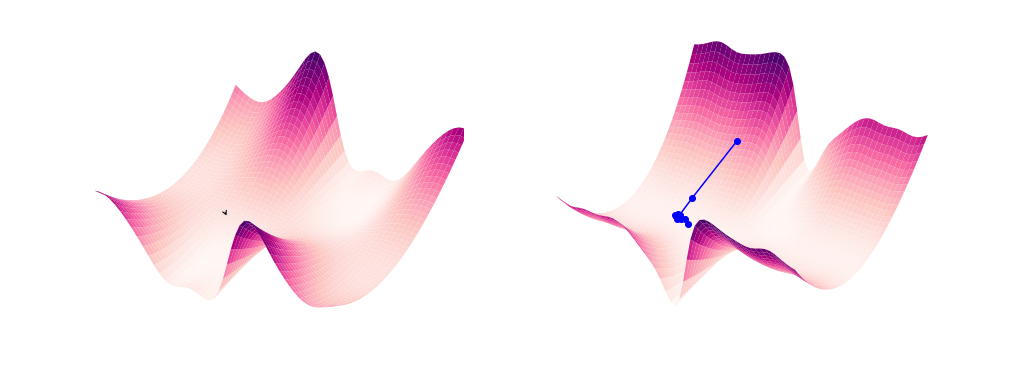

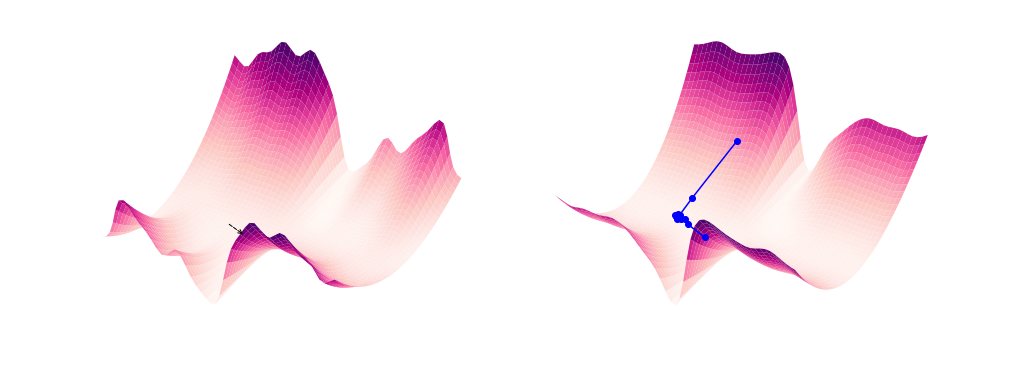

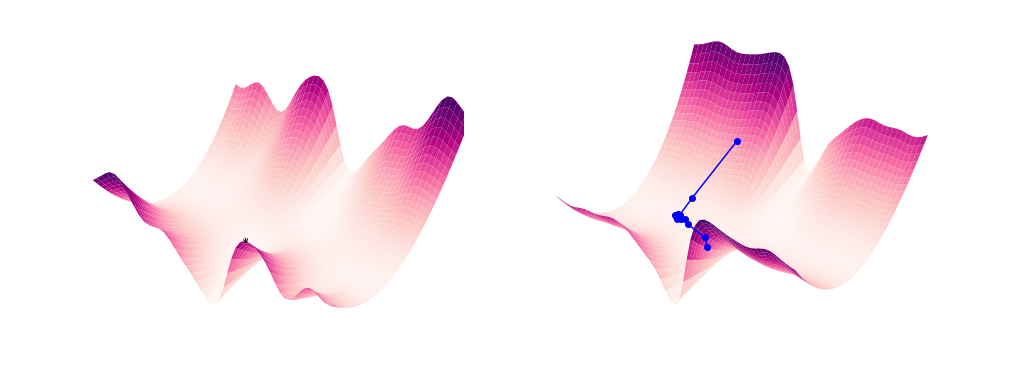

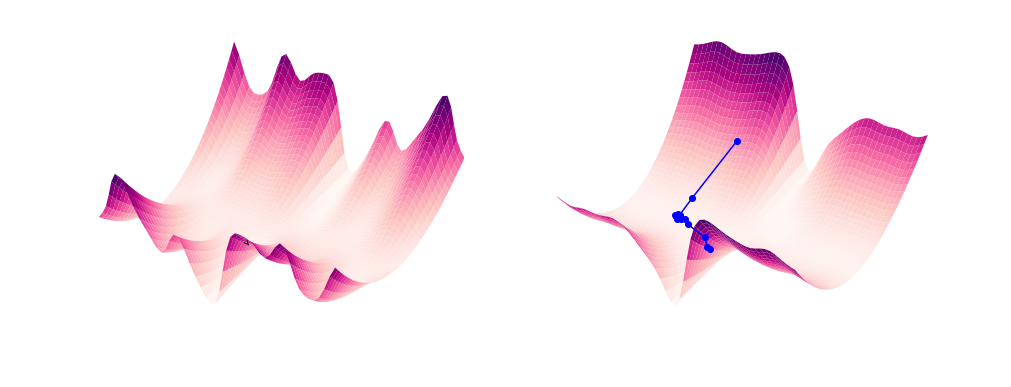

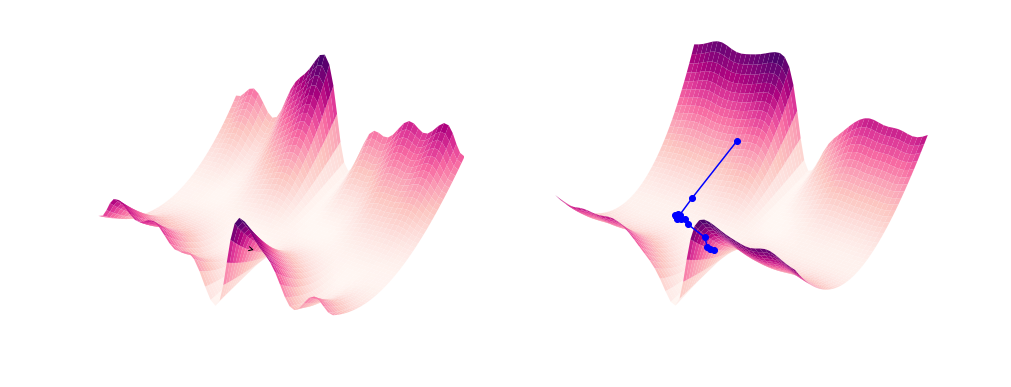

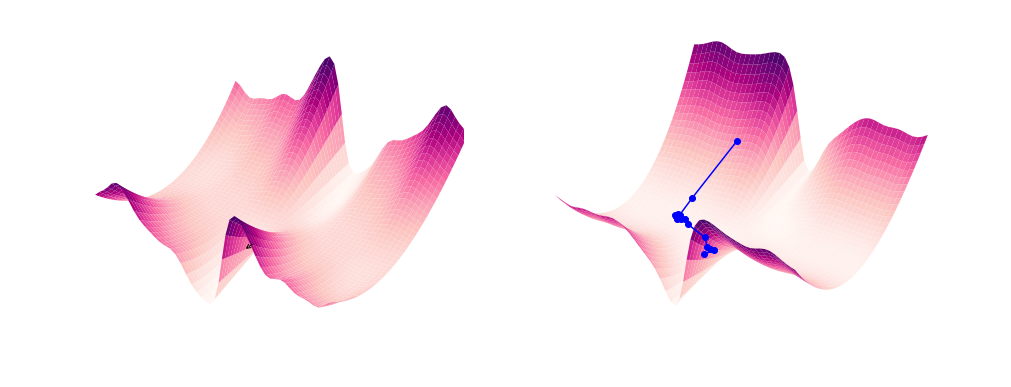

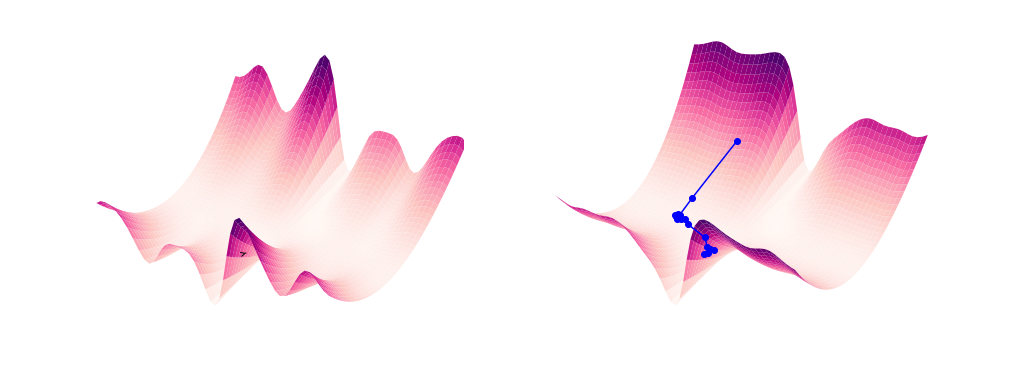

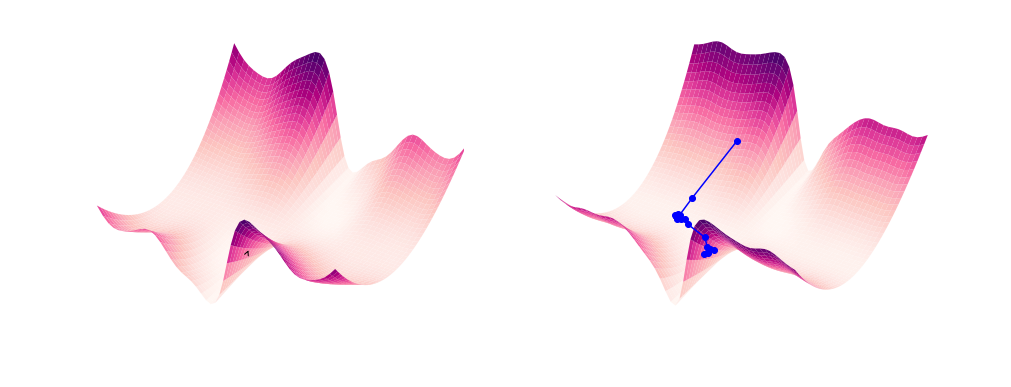

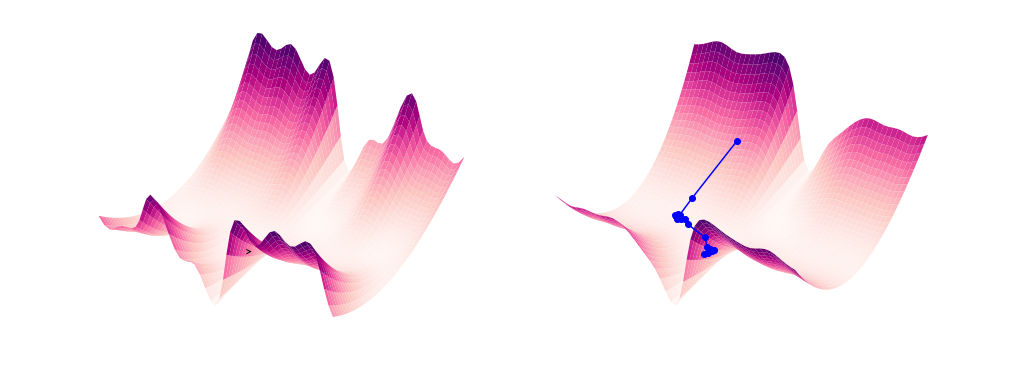

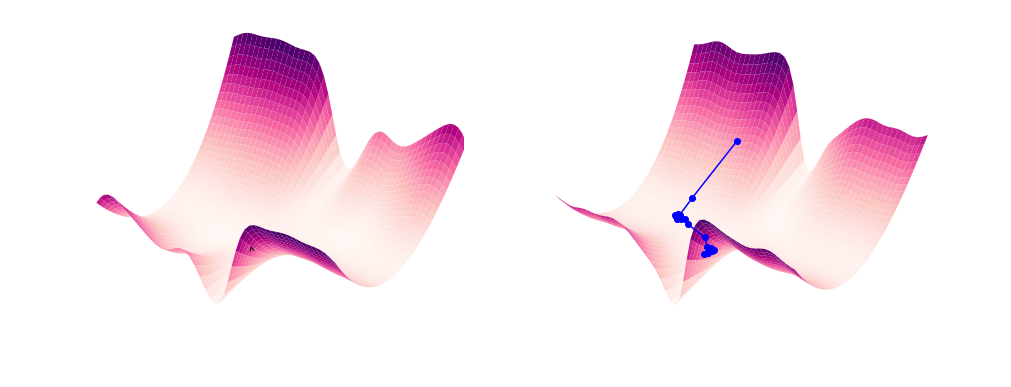

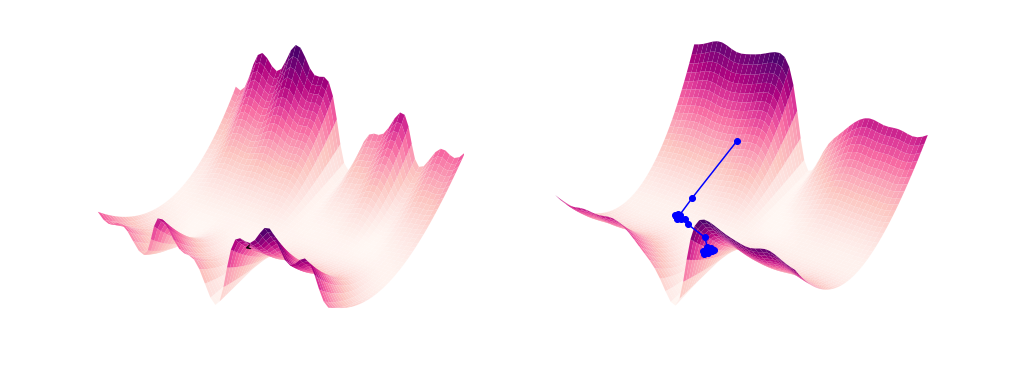

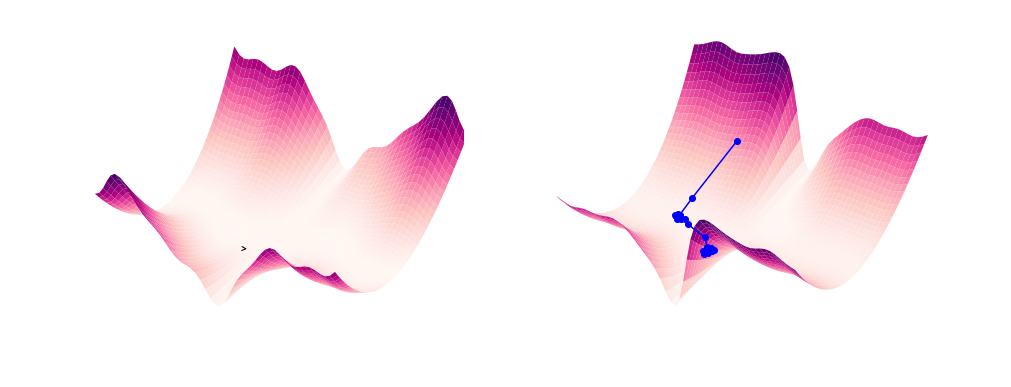

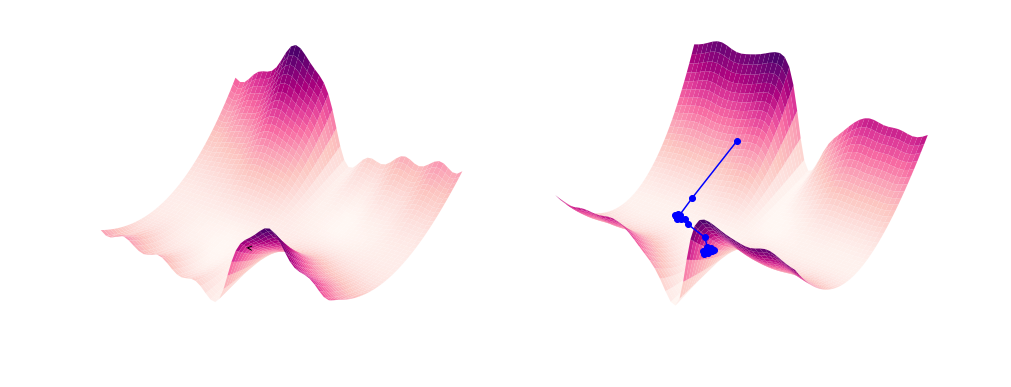

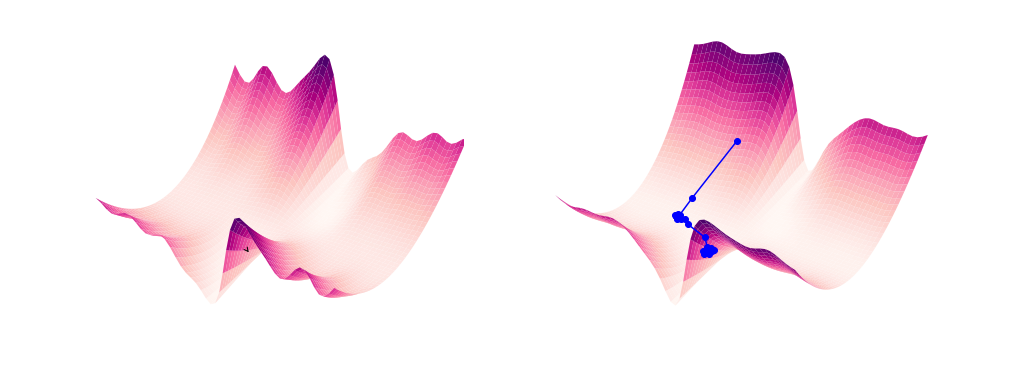

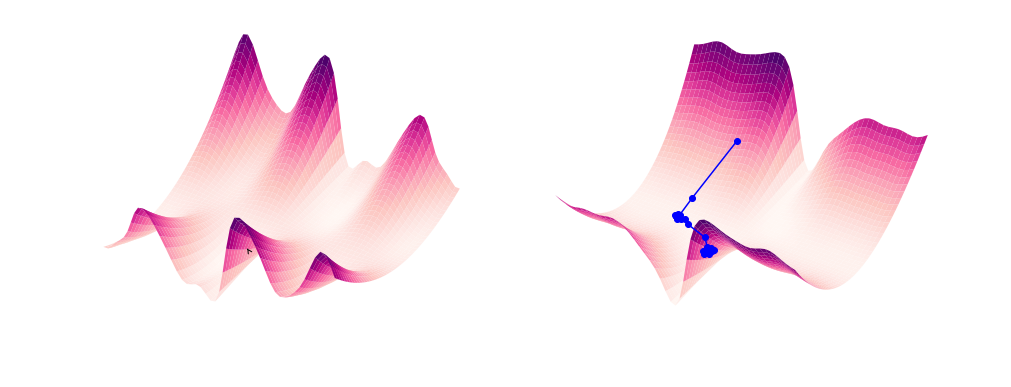

In [47]:
for frame_number in range(frn):
    fig = plt.figure(figsize=(18.0, 7.0), frameon=False)

    ax = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax.plot_surface(X, Y, zarray[:,:,frame_number], cmap="RdPu")
    ax2.plot_surface(X, Y, scores_train, cmap="RdPu", alpha=0.99)
    
    ws = list_of_w_sgd[:frame_number+2]
    cur_scores = [f(w_cur[0], w_cur[1], X_train, y_train) for w_cur in ws]
    ax2.plot(ws[:,0], ws[:,1], cur_scores,'-ob')
    
    ws = list_of_w_sgd[frame_number:frame_number+2]
    xs = [list_of_x_batch[frame_number], list_of_x_batch[frame_number]]
    ys = [list_of_y_batch[frame_number], list_of_y_batch[frame_number]]
    cur_scores = [f(w_cur[0], w_cur[1], batch_x, batch_y) for w_cur, batch_x, batch_y in zip(ws, xs, ys)]
    
    line = 1
    ax.arrow3D(ws[0,0],ws[0,1], cur_scores[0],
                          line*(ws[1,0]-ws[0,0]),line*(ws[1,1]-ws[0,1]), line*(cur_scores[1]-cur_scores[0]),
                          mutation_scale=10,
                          arrowstyle="->",
                          linestyle='dashed')
    
    plt.subplots_adjust(hspace = 0, wspace = -0.155)
    
    


    ax.view_init(60, -150)
    ax2.view_init(60, -150)
    ax.axis('off')
    ax2.axis('off')
    
    plt.savefig('temp/{}.png'.format(frame_number), bbox_inches = 'tight', dpi=300)